In [1]:
#######imports and data read#######
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
gene_list_for_plot = ['CDC20','CDK1','RRM2','PCNA','A1BG']
#adata = sc.read_csv('hela/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt', delimiter='\t').T
adata = sc.read_csv('hela/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T
adata = shuffle_adata(adata)

#######data cleaning#######
#sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=0)
i=1
while adata.obs['n_genes'].mean() <4500: #remove cells until we reach mean counts of 4,500 as suggested by https://www.embopress.org/doi/full/10.15252/msb.20209946
    sc.pp.filter_cells(adata, min_genes=i)
    i+=5
#sc.pp.filter_cells(adata, min_counts=3000) #4000
adata_for_inference = adata.copy()
adata

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


AnnData object with n_obs × n_vars = 683 × 25797
    obs: 'n_genes'

In [2]:

def get_circular_mean_var(adata):
    '''
    Plot all the figures that are related to the HeLa cells section
    :param adata:  AnnData of HeLa cells
    :param title: title for figures
    '''
    cyclic_by_phase = pd.read_csv("data/cyclic_by_phase.csv")
    G1S = score_list_of_genes_single_adata(cyclic_by_phase=cyclic_by_phase, phase="G1.S", adata=adata)
    S = score_list_of_genes_single_adata(cyclic_by_phase=cyclic_by_phase, phase="S", adata=adata)
    G2 = score_list_of_genes_single_adata(cyclic_by_phase=cyclic_by_phase, phase="G2", adata=adata)
    G2M = score_list_of_genes_single_adata(cyclic_by_phase=cyclic_by_phase, phase="G2.M", adata=adata)
    MG1 = score_list_of_genes_single_adata(cyclic_by_phase=cyclic_by_phase, phase="M.G1", adata=adata)
    G1S= G1S[:,0]
    G2= G2[:,0]
    S= S[:,0]
    MG1= MG1[:,0]
    G2M= G2M[:,0]
    G1_len = len(savgol_filter((G1S / G1S.max()),7,5))
    theta = (np.array(range(G1_len)) * 2 * np.pi) / G1_len

    g1s_circular_stats = circular_mean(theta,G1S / np.sum(G1S))
    s_circular_stats = circular_mean(theta,S / np.sum(S))
    g2_circular_stats = circular_mean(theta,G2 / np.sum(G2))
    g2m_circular_stats = circular_mean(theta,G2M / np.sum(G2M))
    mg1_circular_stats = circular_mean(theta,MG1 / np.sum(MG1))
    return ((g1s_circular_stats[1]+s_circular_stats[1]+g2_circular_stats[1
    ] + g2m_circular_stats[1] +mg1_circular_stats[1] )/5), [g1s_circular_stats[0],s_circular_stats[0]
                                                            ,g2_circular_stats[0], 
                                                            g2m_circular_stats[0] , mg1_circular_stats[0]]

In [3]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
bdata = copy.deepcopy(adata.copy())
mean_circuluar = []
mean_circuluar_var= []
hvg_num = []


In [4]:
for i in range(20):
    bdata = copy.deepcopy(adata.copy())
    bdata.X =  np.array(bdata.X).astype('float64')
    sc.pp.filter_genes_dispersion(bdata,n_top_genes=(500*(i+1)))
    E_sga  , E_rec_sga = reconstruction_cyclic(bdata.X , iterNum=100)
    sga_range= e_to_range(E_rec_sga)
    bdata = bdata[sga_range,:]
    mean_var , mean_list = get_circular_mean_var(bdata)
    mean_circuluar_var.append(mean_var)
    mean_circuluar.append(mean_list)
    hvg_num.append((500*(i+1)))

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
6.286110598743417e-25
Iteration number: 
25
 function value= 
1.2168667196633848e-06
Iteration number: 
50
 function value= 
5.538031733319644
Iteration number: 
75
 function value= 
5.740701021437108


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.0902048080649915e-22
Iteration number: 
25
 function value= 
1020.2639682164233
Iteration number: 
50
 function value= 
1031.0762870305696
Iteration number: 
75
 function value= 
1013.8322991259697


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1113380985738488e-22
Iteration number: 
25
 function value= 
894.8501745952485
Iteration number: 
50
 function value= 
927.5127572428174
Iteration number: 
75
 function value= 
922.70162207764


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.090975615014583e-22
Iteration number: 
25
 function value= 
688.1557250350079
Iteration number: 
50
 function value= 
750.8420036017777
Iteration number: 
75
 function value= 
777.2492662087766


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1088682063541264e-22
Iteration number: 
25
 function value= 
683.8345090361863
Iteration number: 
50
 function value= 
715.319280490679
Iteration number: 
75
 function value= 
728.1374509567465


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1110665029630837e-22
Iteration number: 
25
 function value= 
576.481694903392
Iteration number: 
50
 function value= 
674.5762642329065
Iteration number: 
75
 function value= 
649.3683620868926


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.11939701778778e-22
Iteration number: 
25
 function value= 
532.2279311965805
Iteration number: 
50
 function value= 
641.740981134433
Iteration number: 
75
 function value= 
655.4205424752568


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1398781985391972e-22
Iteration number: 
25
 function value= 
444.06367559316845
Iteration number: 
50
 function value= 
611.1878326173575
Iteration number: 
75
 function value= 
622.5187720547779


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1312061572291372e-22
Iteration number: 
25
 function value= 
359.3985268996523
Iteration number: 
50
 function value= 
555.8742520707433
Iteration number: 
75
 function value= 
573.9170683506868


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1460796210361518e-22
Iteration number: 
25
 function value= 
354.97319930885226
Iteration number: 
50
 function value= 
550.9839247031017
Iteration number: 
75
 function value= 
561.6277646674366


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1713906117992887e-22
Iteration number: 
25
 function value= 
360.3849360914139
Iteration number: 
50
 function value= 
557.2893126767315
Iteration number: 
75
 function value= 
565.1982655512979


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.173726075178571e-22
Iteration number: 
25
 function value= 
353.6212541929781
Iteration number: 
50
 function value= 
540.6646764921156
Iteration number: 
75
 function value= 
539.8605337971821


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1893096524552543e-22
Iteration number: 
25
 function value= 
343.330139454703
Iteration number: 
50
 function value= 
528.5000990137974
Iteration number: 
75
 function value= 
537.2518987343412


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1929998464817076e-22
Iteration number: 
25
 function value= 
335.89704156895675
Iteration number: 
50
 function value= 
535.8232815526786
Iteration number: 
75
 function value= 
544.3170565951475


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1730145211655712e-22
Iteration number: 
25
 function value= 
290.5985685521986
Iteration number: 
50
 function value= 
475.12882492161475
Iteration number: 
75
 function value= 
464.6893130016959


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1662819613288966e-22
Iteration number: 
25
 function value= 
295.19929083155455
Iteration number: 
50
 function value= 
452.52481298592363
Iteration number: 
75
 function value= 
474.35461815230474


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1715152374321262e-22
Iteration number: 
25
 function value= 
279.0285459210083
Iteration number: 
50
 function value= 
412.1634067075541
Iteration number: 
75
 function value= 
451.87213411593905


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1762138548893552e-22
Iteration number: 
25
 function value= 
264.6883190155163
Iteration number: 
50
 function value= 
414.94165842789386
Iteration number: 
75
 function value= 
440.9112818069123


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1928709356507378e-22
Iteration number: 
25
 function value= 
257.8726764270588
Iteration number: 
50
 function value= 
410.10815103154016
Iteration number: 
75
 function value= 
441.1729935291693


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iteration number: 
0
 function value= 
1.1990803098743834e-22
Iteration number: 
25
 function value= 
226.65555535210154
Iteration number: 
50
 function value= 
403.8867197478125
Iteration number: 
75
 function value= 
437.32818490329413


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_22014/1006678004.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot((np.array(hvg_num)),(np.array(mean_circuluar_var)), 'bo',color='b')


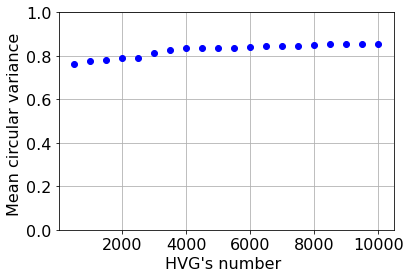

In [5]:
fig, ax = plt.subplots()

ax.plot((np.array(hvg_num)),(np.array(mean_circuluar_var)), 'bo',color='b')
ax.set_xlabel("HVG's number " ,  fontsize=16)
ax.set_ylabel("Mean circular variance " ,  fontsize=16)
plt.tick_params(labelsize=16)
ax.grid(True)
ax.set_ylim([0, 1])
plt.show()

In [6]:
mean_c = np.array(mean_circuluar)
mean_c.shape

(20, 5)

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_22014/1780797329.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot((np.array(hvg_num)),(np.array(mean_c[:,0])), 'bo',color='b' , label='G1S')
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_22014/1780797329.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot((np.array(hvg_num)),(np.array(mean_c[:,1])), 'bo',color='r' , label='S')
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_22014/1780797329.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot((np.array(hvg_num)),(np.array(mean_c[:,2])), 'bo',color='g' , label='G2')
/var/folders/yk/yt973zks3y50tkw

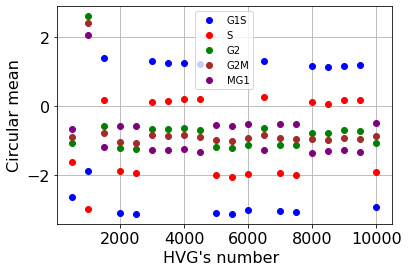

In [11]:
fig, ax = plt.subplots()

ax.plot((np.array(hvg_num)),(np.array(mean_c[:,0])), 'bo',color='b' , label='G1S')
ax.plot((np.array(hvg_num)),(np.array(mean_c[:,1])), 'bo',color='r' , label='S')
ax.plot((np.array(hvg_num)),(np.array(mean_c[:,2])), 'bo',color='g' , label='G2')
ax.plot((np.array(hvg_num)),(np.array(mean_c[:,3])), 'bo',color='brown' , label='G2M')
ax.plot((np.array(hvg_num)),(np.array(mean_c[:,4])), 'bo',color='purple' , label='MG1')
ax.set_xlabel("HVG's number " ,  fontsize=16)
ax.set_ylabel("Circular mean" ,  fontsize=16)
plt.tick_params(labelsize=16)
ax.grid(True)
plt.legend()
plt.show()